# Analysis of VoC data

Look at data provided to SPI-M on the B.1.351 VoC. 

Data file not included in the repo, so change path if running independently. 

This version:
* Data is that provided on 7 May
* Be clearer about travel versus non - London non-travel seems to have consistent exp.
* Be clearer about exponential versus constant
* Clearer labels of calendar dates

Note that linkage to the linelist on finalid should be possible.

In [77]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import scipy.special as sp
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import scipy.optimize as op
from numpy import linalg as LA

In [2]:
df = pd.read_excel(
    '/Volumes/COVID19_Epi_modelling/DstlDailyData/2021-05-07/VOC202012_02_linelist_20210507.xlsx',
    sheet_name=1,
)
df.dropna(subset=['earliest_specimen_date'],inplace=True)

In [3]:
df

,finalid,specimen_date_sk,seq_result,earliest_specimen_date,PHEC_name,exposure_type,survey_or_intervention,hh_id
0,-3311559.0,20210503.0,Provisional Genotyping,2021-05-03,West Midlands,Awaiting information,NaN,1.0
1,-3311042.0,20210502.0,Provisional Genotyping,2021-05-02,London,Awaiting information,NaN,2.0
2,-3306285.0,20210428.0,Provisional Genotyping,2021-04-28,London,Awaiting information,NaN,277.0
3,-3304744.0,20210501.0,Provisional Genotyping,2021-04-29,London,Awaiting information,NaN,593.0
4,-3304640.0,20210428.0,Provisional Genotyping,2021-04-28,London,Awaiting information,NaN,293.0
...,...,...,...,...,...,...,...,...
742,1673679.0,20210420.0,Confirmed,2021-04-20,London,Awaiting information,NaN,490.0
743,1673685.0,20210419.0,Confirmed,2021-04-19,London,Awaiting information,NaN,333.0
744,1673719.0,20201227.0,Confirmed,2020-12-27,East of England,Contact of Traveller,NaN,585.0
745,1674785.0,20210422.0,Confirmed,2021-04-22,South West,Awaiting information,NaN,270.0


In [4]:
def todays(x):
    return np.array((pd.to_datetime(x['earliest_specimen_date'], format='%Y-%m-%d') - pd.Timestamp("2020-10-01")) // pd.Timedelta('1D'))

In [25]:
monthstarts = pd.DataFrame([
    '2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01'
],columns=['earliest_specimen_date'])
monthstarts

,earliest_specimen_date
0,2020-10-01
1,2020-11-01
2,2020-12-01
3,2021-01-01
4,2021-02-01
5,2021-03-01
6,2021-04-01
7,2021-05-01


In [26]:
def tods(x):
    return pd.to_datetime(x['earliest_specimen_date'], format='%Y-%m-%d').dt.strftime('%d %b')

In [27]:
keydates = pd.DataFrame([
    ['2021-01-01','Start of 2021'],
    ['2021-03-08','Roadmap Start'],
    ['2021-04-30','Sequence Delay'],
],columns=['earliest_specimen_date','date_name'])
keydates

,earliest_specimen_date,date_name
0,2021-01-01,Start of 2021
1,2021-03-08,Roadmap Start
2,2021-04-30,Sequence Delay


In [28]:
dfr = df.groupby('PHEC_name').apply(todays)

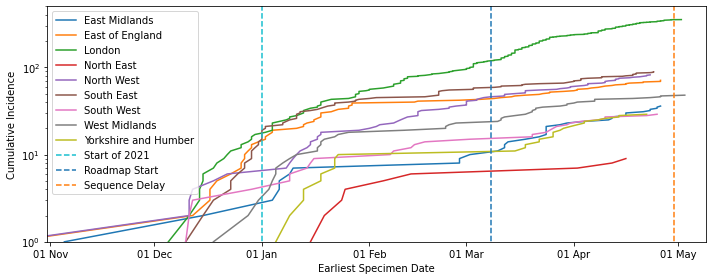

In [29]:
plt.figure(figsize=(10,4))
for i in range(0,len(dfr.index)):
    x = dfr[i]
    plt.plot(np.sort(x),np.arange(1,len(x)+1),label=dfr.index[i])
for i, d in keydates.iterrows():
    plt.plot(todays(d)*np.ones(2),np.array([0,500]),ls='--',label=d.date_name)
plt.legend()
plt.xlabel('Earliest Specimen Date')
plt.ylabel('Cumulative Incidence')
plt.xticks(todays(monthstarts),tods(monthstarts))
plt.xlim([30,220])
plt.ylim([1,500])
plt.yscale('log')
plt.tight_layout()
#plt.savefig('./voc_region_log.pdf')

In [16]:
# From the above, London is far largest so look at that
li = np.argwhere(dfr.index == 'London')[0]
x = dfr[li].values[0]

In [17]:
dfl = df[df.PHEC_name == 'London']
dfl.reset_index(drop=True,inplace=True)
dfl

,finalid,specimen_date_sk,seq_result,earliest_specimen_date,PHEC_name,exposure_type,survey_or_intervention,hh_id
0,-3311042.0,20210502.0,Provisional Genotyping,2021-05-02,London,Awaiting information,NaN,2.0
1,-3306285.0,20210428.0,Provisional Genotyping,2021-04-28,London,Awaiting information,NaN,277.0
2,-3304744.0,20210501.0,Provisional Genotyping,2021-04-29,London,Awaiting information,NaN,593.0
3,-3304640.0,20210428.0,Provisional Genotyping,2021-04-28,London,Awaiting information,NaN,293.0
4,-3304562.0,20210501.0,Provisional Genotyping,2021-04-29,London,Awaiting information,NaN,512.0
...,...,...,...,...,...,...,...,...
348,1672607.0,20210416.0,Confirmed,2021-04-16,London,Awaiting information,NaN,487.0
349,1672956.0,20210410.0,Confirmed,2021-04-10,London,Not travel-associated,NaN,488.0
350,1673678.0,20210419.0,Confirmed,2021-04-19,London,Awaiting information,NaN,489.0
351,1673679.0,20210420.0,Confirmed,2021-04-20,London,Awaiting information,NaN,490.0


In [63]:
dfg.index

Index(['Awaiting information', 'Contact of Traveller', 'Not travel-associated',
       'Refused or Uncontactable', 'Traveller'],
      dtype='object', name='exposure_type')

In [18]:
dfg = df.groupby('exposure_type').apply(todays)

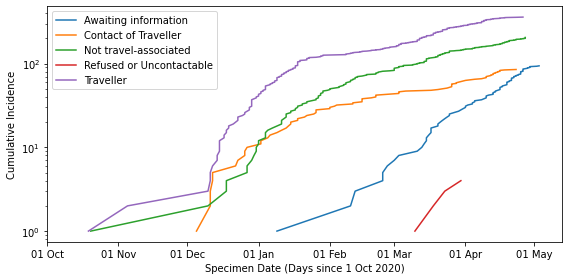

In [30]:
plt.figure(figsize=(8,4))
for i in range(0,len(dfg.index)):
    x = dfg[i]
    plt.plot(np.sort(x),np.arange(1,len(x)+1),label=dfg.index[i])
plt.legend()
plt.xlabel('Specimen Date (Days since 1 Oct 2020)')
plt.ylabel('Cumulative Incidence')
plt.xticks(todays(monthstarts),tods(monthstarts))
#plt.ylim([50,300])
#plt.xlim([60,180])
plt.yscale('log')
plt.tight_layout()
#plt.savefig('./voc_c.pdf')

In [33]:
# From the above, Not travel London
li = np.argwhere(dfg.index == 'Not travel-associated')[0]
x = dfg[li].values[0]
len(x)

205

In [34]:
def mymu(x,tt,n):
    mu = np.concatenate([
        x[0]*np.exp(x[1]*tt[0:n]),
        x[0]*np.exp(x[1]*tt[n-1])*np.exp(x[3]*(tt[n:]-tt[n-1]))
    ])
    return mu

def myod(x,tt,n):
    od = np.concatenate([
        x[2]*np.ones(len(tt[0:n])),
        x[4]*np.ones(len(tt[n:]))
    ])
    return od

def mynll(y,x,tt):
    mu = x[0]*np.exp(x[1]*tt)
    od = x[2]*np.ones(len(tt))
    p = 1/od
    r = mu/(od-1)
    return -np.sum(st.nbinom.logpmf(y,r,p))

def mynll2(y,x,tt,n):
    mu = mymu(x,tt,n)
    od = myod(x,tt,n)
    p = 1/od
    r = mu/(od-1)
    return -np.sum(st.nbinom.logpmf(y,r,p))

Text(0, 0.5, 'New cases')

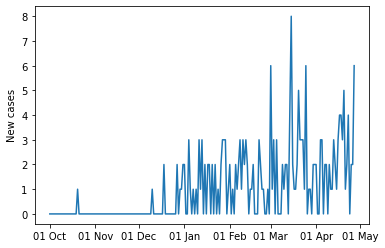

In [91]:
z = np.bincount(x)
uu = np.arange(0,np.max(x)+1)
plt.plot(uu,z)
plt.xticks(todays(monthstarts),tods(monthstarts))
plt.ylabel('New cases')

In [56]:
keydates = pd.DataFrame([
    ['2021-01-01','Start of 2021'],
    ['2021-03-08','Roadmap Start'],
    ['2021-04-30','Sequence Delay'],
],columns=['earliest_specimen_date','date_name'])
keydates

,earliest_specimen_date,date_name
0,2021-01-01,Start of 2021
1,2021-03-08,Roadmap Start
2,2021-04-30,Sequence Delay


In [57]:
tk = todays(keydates)
z = np.bincount(x)
yy = z[tk[0]:tk[-1]]
tt = np.arange(0,len(yy))
n = tk[1]-tk[0]

In [92]:
x02 = np.array([1,0.25,5,0.15,5])
nll = lambda xx: mynll2(yy,xx,tt,n)
fout2 = op.minimize(nll,x02,method='Nelder-Mead')   
mu = mymu(fout2.x,tt,n)
od = myod(fout2.x,tt,n)
p = 1/od
r = mu/(od-1)
dt1 = np.log(2.0)/fout2.x[1]
dt2 = np.log(2.0)/fout2.x[3]
print(dt1)
print(dt2)

134.43721331933065
66.07347393719384


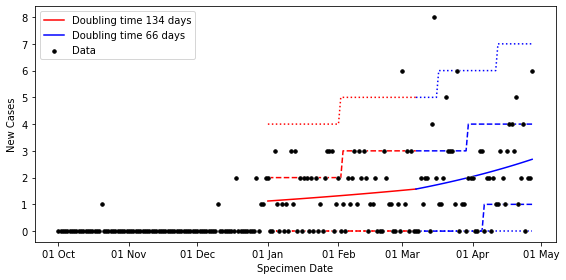

In [104]:
plt.figure(figsize=(8,4))
plt.xlabel('Specimen Date')
plt.ylabel('New Cases')
plt.xticks(todays(monthstarts),tods(monthstarts))
plt.plot(tk[0]+tt[0:n],mu[0:n],linestyle='-',c='r',label='Doubling time {:.0f} days'.format(dt1))
plt.plot(tk[0]+tt[(n-1):],mu[(n-1):],linestyle='-',c='b',label='Doubling time {:.0f} days'.format(dt2))
plt.plot(tk[0]+tt[0:n],st.nbinom.ppf(1/6,r[0:n],p[0:n]),linestyle='--',c='r')
plt.plot(tk[0]+tt[0:n],st.nbinom.ppf(5/6,r[0:n],p[0:n]),linestyle='--',c='r')
plt.plot(tk[0]+tt[(n-1):],st.nbinom.ppf(1/6,r[(n-1):],p[(n-1):]),linestyle='--',c='b')
plt.plot(tk[0]+tt[(n-1):],st.nbinom.ppf(5/6,r[(n-1):],p[(n-1):]),linestyle='--',c='b')
plt.plot(tk[0]+tt[0:n],st.nbinom.ppf(0.025,r[0:n],p[0:n]),linestyle=':',c='r')
plt.plot(tk[0]+tt[0:n],st.nbinom.ppf(0.975,r[0:n],p[0:n]),linestyle=':',c='r')
plt.plot(tk[0]+tt[(n-1):],st.nbinom.ppf(0.025,r[(n-1):],p[(n-1):]),linestyle=':',c='b')
plt.plot(tk[0]+tt[(n-1):],st.nbinom.ppf(0.975,r[(n-1):],p[(n-1):]),linestyle=':',c='b')
plt.scatter(uu,z,marker='o',c='w',s=16,zorder=3)
plt.scatter(uu,z,marker='o',c='k',s=12,label='Data',zorder=3)
plt.legend()
plt.tight_layout()
#plt.savefig('./voc_c.pdf')

In [80]:
xhat = fout2.x
xhat

array([1.12430246, 0.00515592, 1.29482544, 0.01049055, 1.40135644])

In [84]:
pn = len(x02)
delta = 1e-2 # Some tuning of this by hand is inevitable
dx = delta*xhat
ej = np.zeros(pn)
ek = np.zeros(pn)
Hinv = np.zeros((pn,pn))
for j in range(0,pn):
    ej[j] = dx[j]
    for k in range(0,j):
        ek[k] = dx[k]
        Hinv[j,k] = nll(xhat+ej+ek) - nll(xhat+ej-ek) - nll(xhat-ej+ek) + nll(xhat-ej-ek)
        ek[k] = 0.
    Hinv[j,j] = - nll(xhat+2*ej) + 16*nll(xhat+ej) - 30*nll(xhat) + 16*nll(xhat-ej) - nll(xhat-2*ej)
    ej[j] = 0.
Hinv += np.triu(Hinv.T,1)
Hinv /= (4.*np.outer(dx,dx) + np.diag(8.*dx**2)) # TO DO: replace with a chol ...
covmat = LA.inv(0.5*(Hinv+Hinv.T))
stds = np.sqrt(np.diag(covmat))
print(stds)

[0.26509632 0.00519759 0.28338963 0.00597192 0.28357679]


In [74]:
dfs = pd.read_csv('./perc_r_eng.csv')

In [64]:
def stodays(x):
    return np.array((pd.to_datetime(x['Date'], format='%d-%b-%y') - pd.Timestamp("2020-10-01")) // pd.Timedelta('1D'))

In [72]:
gl = dfs.Lower.values/100
gu = dfs.Upper.values/100
gt = stodays(dfs)-7 # Assume that the SPI-M estimates come with a 7 day delay

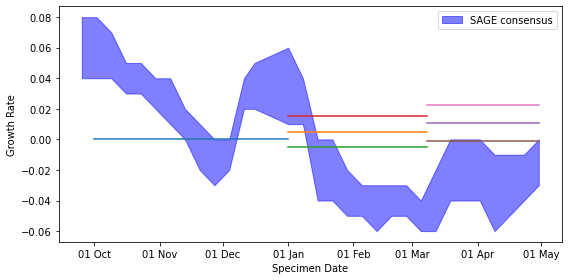

In [112]:
#plt.plot(gt,gl)
#plt.plot(gt,gu)
plt.figure(figsize=(8,4))
plt.xlabel('Specimen Date')
plt.ylabel('Growth Rate')
plt.xticks(todays(monthstarts),tods(monthstarts))
plt.fill_between(gt,gl,gu,color='b',alpha=0.5,label='SAGE consensus')
plt.plot(np.array([0,tk[0]]),0.0*np.ones(2))
plt.plot(np.array([tk[0],tk[1]]),xhat[1]*np.ones(2))
plt.plot(np.array([tk[0],tk[1]]),(xhat[1]-1.96*stds[1])*np.ones(2))
plt.plot(np.array([tk[0],tk[1]]),(xhat[1]+1.96*stds[1])*np.ones(2))
plt.plot(np.array([tk[1],tk[2]]),xhat[3]*np.ones(2))
plt.plot(np.array([tk[1],tk[2]]),(xhat[3]-1.96*stds[3])*np.ones(2))
plt.plot(np.array([tk[1],tk[2]]),(xhat[3]+1.96*stds[3])*np.ones(2))
plt.legend()
plt.tight_layout()
#plt.savefig('./voc_c.pdf')